## Семинар 5: "Улучшение сходимости нейросетей"

ФИО: Долгая Анастасия Васильевна

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
%matplotlib inline

На этом семинаре мы попробуем улучшить результаты, полученные на предыдущем занятии
Для этого нам понадобятся следующие вещи:
* Dropout
* Batch Normalization
* Инициализация весов

### Часть 1: Инициализация весов

На лекции доказывалось, что при инициализации He и Glorot дисперсия активаций градиентов в каждом слое будут примерно равны. Давайте проверим это. 

In [2]:
# Dataloader
to_numpy = lambda x: x.numpy()
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

In [3]:
images_train, labels_train = next(iter(train_loader))

In [4]:
## Usage example:
for X, y in train_loader:
    X = X.view(X.size(0), -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy()
    pass

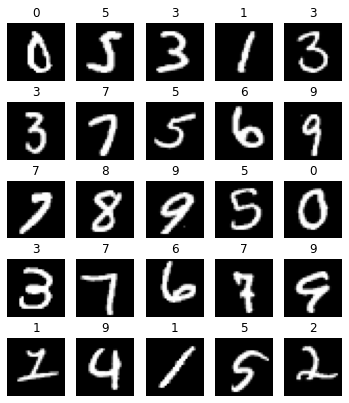

In [5]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

<i> 1.1 </i> Инициализируйте полносвязную сеть нормальным шумом N(0, 0.1) с архитектурой 784 -> 500 x (10 раз) -> 10. В качестве активации возьмите tanh

In [6]:
def init_layer(layer, mean=0, std=1):
    # Тут надо быть аккуратным — можно случайно создать копию и менять значения у копии
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    #1 - веса сети
    #2 - нули ...
    #bias = torch.zeros_like(bias)
    weight.normal_(mean=0, std=std)

def forward_hook(self, input_, output):
    std = input_[0].std().item()
    print('forward', std)

def backward_hook(self, grad_input, grad_output):
    std = grad_input[0].std().item()
    print('backward', std)

    
# пример:
layer = nn.Linear(28*28, 10)
layer.register_forward_hook(forward_hook)
layer.register_backward_hook(backward_hook)
init_layer(layer, 0.0, 0.1) # сюда надо подставить другие параметры

In [7]:
sizes = [784] + [500] * 10 + [10]
layers = []

def normal(size_input, size_output):
    return 0.1
    #return 1

def xavier(size_input, size_output):
    d = 2 / (size_input + size_output)
    return np.sqrt(d)

def good_grad(size_input, size_output):
    d = 1 / size_output
    return np.sqrt(d)

#init_func = normal
init_func = xavier
#init_func = good_grad

for size_input, size_output in zip(sizes, sizes[1:]):
    
    layer = nn.Linear(size_input, size_output)
    layer.register_forward_hook(forward_hook)
    layer.register_backward_hook(backward_hook)
    init_layer(layer, 0.0, init_func(size_input, size_output)) # сюда надо подставить другие параметры
    
    layers.append(layer)
    #layers.append(nn.Tanh())
    #layers.append(nn.Sigmoid())
    layers.append(nn.Tanh())
    
print(len(layers))
del layers[-1]

22


<i>1.2 Пропустите батч изображений через нейронную сеть и вычислите дисперсию активаций. Затем вычислите градиент и получите дисперсию градиентов. Сравните эти значения между собой для разных слоев.</i>

In [8]:
network = nn.Sequential(*layers)

#пример:
n_objects = 100
X = images_train[:n_objects].view(n_objects, -1).data
y = labels_train[:n_objects].data
activations = network(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(network.parameters(), lr=0.001) 
loss = loss_fn(activations, y)
loss.backward()

forward 0.9937963485717773
forward 0.6498644948005676
forward 0.4998296797275543
forward 0.41497868299484253
forward 0.3565751612186432
forward 0.3201674520969391
forward 0.29659613966941833
forward 0.2769096791744232
forward 0.25669729709625244
forward 0.24032089114189148
forward 0.2293611317873001
backward 0.026666663587093353
backward 0.0202034879475832
backward 0.01792614720761776
backward 0.01705913059413433
backward 0.014891307801008224
backward 0.013779415749013424
backward 0.012976338155567646
backward 0.011103963479399681
backward 0.00937175564467907
backward 0.00669403700158
backward 0.004188829567283392


<i>1.3 Повторите эксперимент для инициализаций He и Xavier (формулы есть в лекции).</i>

In [9]:
##### YOUR CODE HERE #####
def init_he(size_input, size_output):
    d = 2 / size_output
    return np.sqrt(d)

In [10]:
init_func = xavier
sizes = [784] + [500] * 10 + [10]
layers = []  
for size_input, size_output in zip(sizes, sizes[1:]):
    
    layer = nn.Linear(size_input, size_output)
    layer.register_forward_hook(forward_hook)
    layer.register_backward_hook(backward_hook)
    init_layer(layer, 0.0, init_func(size_input, size_output)) 
    
    layers.append(layer)
    layers.append(nn.ReLU())
network = nn.Sequential(*layers)
#пример:
n_objects = 100
X = images_train[:n_objects].view(n_objects, -1).data
y = labels_train[:n_objects].data
activations = network(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(network.parameters(), lr=0.001) 
loss = loss_fn(activations, y)
loss.backward()

forward 0.9937963485717773
forward 0.6693623065948486
forward 0.48670709133148193
forward 0.3555932343006134
forward 0.24249622225761414
forward 0.16796857118606567
forward 0.12130691111087799
forward 0.08538556098937988
forward 0.06039566919207573
forward 0.042907826602458954
forward 0.030136024579405785
backward 0.03864366561174393
backward 0.006438560783863068
backward 0.003897304181009531
backward 0.0026216725818812847
backward 0.0016374366823583841
backward 0.001051311264745891
backward 0.0007010758272372186
backward 0.0004967730492353439
backward 0.0003532572591211647
backward 0.0002268188982270658
backward 0.00015004168380983174


In [11]:
init_func = init_he
sizes = [28*28] + [500] * 10 + [10]
layers = []  
for size_input, size_output in zip(sizes, sizes[1:]):
    
    layer = nn.Linear(size_input, size_output)
    layer.register_forward_hook(forward_hook)
    layer.register_backward_hook(backward_hook)
    init_layer(layer, 0.0, init_func(size_input, size_output)) 
    
    layers.append(layer)
    layers.append(nn.ReLU())
network = nn.Sequential(*layers)
n_objects = 100
X = images_train[:n_objects].view(n_objects, -1).data
y = labels_train[:n_objects].data
activations = network(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(network.parameters(), lr=0.001) 
loss = loss_fn(activations, y)
loss.backward()

forward 0.9937963485717773
forward 1.0730563402175903
forward 1.0772016048431396
forward 1.0883868932724
forward 1.1263049840927124
forward 1.1650021076202393
forward 1.1423486471176147
forward 1.1245863437652588
forward 1.1086076498031616
forward 1.1199737787246704
forward 1.1748416423797607
backward 0.04547281935811043
backward 0.07253991812467575
backward 0.0704583078622818
backward 0.058345917612314224
backward 0.056646350771188736
backward 0.05143439397215843
backward 0.05133328214287758
backward 0.04976748302578926
backward 0.04841681569814682
backward 0.04358163848519325
backward 0.03789934888482094


<i> 1.4 Сделайте выводы по первой части </i>

С инициализацией He работает немного хуже

### Часть 2: Dropout

Другим полезным слоем является Dropout. В нем с вероятностью 1-p зануляется выход каждого нейрона. Этот слой уже реализован в pyTorch, поэтому вновь реализовывать его не интересно. Давайте реализуем DropConnect — аналог Dropout. В нем с вероятностью 1-p зануляется каждый вес слоя.

<i> 2.1 Реализуйте линейный слой с DropConnect </i>

In [12]:
# полезная функция: .bernoulli_(p)
# не забывайте делать requires_grad=False у маски
# помните, что в вычислениях должны участвовать Variable, а не тензоры


class DropConnect(nn.Module):
    def __init__(self, input_dim, output_dim, p=0.5):
        super(DropConnect, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        self.p = p

    def forward(self, x):    
        mask = torch.zeros_like(self.linear.weight) + self.p
        if self.training:          
            mask.bernoulli_()

        mask = mask.data
        output = F.linear(x, self.linear.weight * mask, self.linear.bias)
        return output

<i> 
2.2 Сравните графики обучения нейроных сетей:
1. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Dropout между всеми слоями 
2. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU DropConnect вместо всех линейных слоев
</i>

In [13]:
sizes = [196, 128, 128, 10]
layers = []
for size_input, size_output in zip(sizes, sizes[1:]):
    layer = nn.Linear(size_input, size_output)
    layer = DropConnect(size_input, size_output, 0.9)
    
    layers.append(layer)
    #layers.append(nn.Dropout(0.3))
    layers.append(nn.ReLU())

del layers[-1]

In [14]:
class TestNetwork(nn.Module):
    def __init__(self, final_part):
        super().__init__()    
        
        channels = 1
        
        self.conv_layers = nn.Sequential(
            nn.Conv2d(channels, 2, 3, padding=1),    
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(2, 4, 3, padding=1),            
            nn.MaxPool2d(2),
            nn.ReLU(),
        )
        
        #input_size = 7 * 7 * 4 = 196
        self.flatten = nn.Flatten()
        
        self.final_part = final_part
        
        self.log_softmax = nn.LogSoftmax(1)        
        
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.flatten(x)
        x = self.final_part(x)
        return self.log_softmax(x)

Epoch 9... (Train/Test) NLL: 0.166/0.291	Accuracy: 0.950/0.973


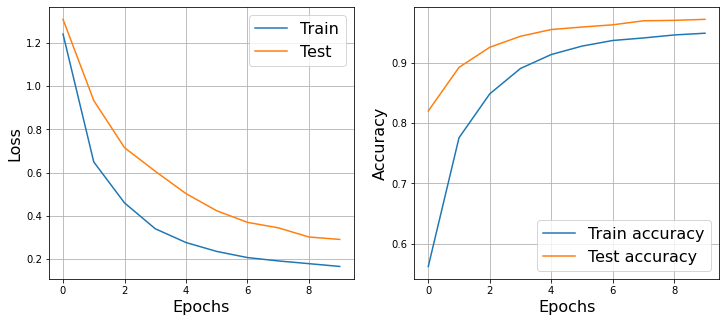

CPU times: user 13min 10s, sys: 8.66 s, total: 13min 19s
Wall time: 2min 17s


([1.2411694235639024,
  0.649179445337385,
  0.4597186472878527,
  0.3400464112252823,
  0.27624895857341253,
  0.23506923474228458,
  0.2066217167163963,
  0.19117434344280249,
  0.17846013880424152,
  0.16557886678653994],
 [1.3094871247871012,
  0.933515922178196,
  0.7154333246282384,
  0.6062557307290078,
  0.5027756442027048,
  0.4233150477086406,
  0.369646308557543,
  0.3443795268880007,
  0.3018669005412656,
  0.2906775715645945],
 [0.5619281,
  0.77585286,
  0.8488084,
  0.89099145,
  0.91414577,
  0.92814386,
  0.93748885,
  0.9416811,
  0.94667846,
  0.94956577],
 [0.8203125,
  0.8928006,
  0.92622626,
  0.94452137,
  0.9556962,
  0.95984966,
  0.9635087,
  0.9702334,
  0.9709256,
  0.9726068])

In [15]:
%%time

#blank
from train_utils import train

network = TestNetwork(nn.Sequential(*layers))

train(network, train_loader, test_loader, 10, 0.001)

In [16]:
sizes = [196, 128, 128, 10]
layers = []
for size_input, size_output in zip(sizes, sizes[1:]):
    layer = nn.Linear(size_input, size_output)
#     layer = DropConnect(size_input, size_output, 0.9)
    
    layers.append(layer)
    layers.append(nn.Dropout(0.3))
    layers.append(nn.ReLU())

del layers[-1]

Epoch 9... (Train/Test) NLL: 0.467/0.065	Accuracy: 0.774/0.980


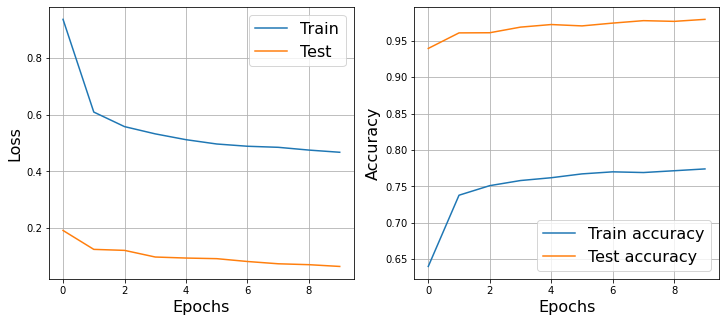

CPU times: user 13min 45s, sys: 8.14 s, total: 13min 53s
Wall time: 2min 25s


([0.935616588732327,
  0.6089415578826912,
  0.5576552026180316,
  0.5320695059131711,
  0.5116000425205556,
  0.4963792758201485,
  0.4884358626693042,
  0.48471039628931706,
  0.4749389278100752,
  0.4672395906595787],
 [0.1917191052550002,
  0.12506291062771518,
  0.12153812232604132,
  0.098110183318959,
  0.09449246740322324,
  0.09231949901161125,
  0.08233733748710609,
  0.0743052329443678,
  0.07111478601641293,
  0.06490532247514665],
 [0.64003646,
  0.73790646,
  0.7510439,
  0.7580735,
  0.76192147,
  0.7672075,
  0.7700282,
  0.76906765,
  0.77153295,
  0.77403164],
 [0.93957675,
  0.9609375,
  0.96113527,
  0.9688489,
  0.972409,
  0.9705301,
  0.9743869,
  0.9777492,
  0.97676027,
  0.97952926])

In [17]:
%%time

#dropout
from train_utils import train

network = TestNetwork(nn.Sequential(*layers))
train(network, train_loader, test_loader, 10, 0.001)

Epoch 9... (Train/Test) NLL: 0.145/0.217	Accuracy: 0.954/0.974


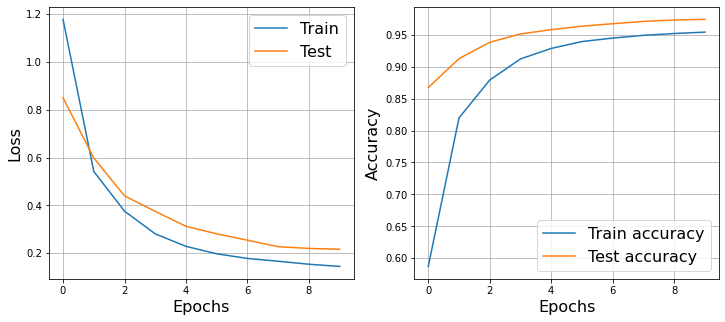

CPU times: user 14min 14s, sys: 8.89 s, total: 14min 23s
Wall time: 2min 33s


([1.1783276582831768,
  0.5421732649493065,
  0.3761504371600873,
  0.2812439844425299,
  0.2289154350932346,
  0.1978012524418104,
  0.17842833460298682,
  0.16672880742659194,
  0.1542001915102733,
  0.1449711634151971],
 [0.8504683516825302,
  0.598563597549366,
  0.4402785623752618,
  0.37520507795594726,
  0.3127755319487427,
  0.28138267966812547,
  0.2546325226437228,
  0.2275776538973574,
  0.2203401273250568,
  0.21688134892091399],
 [0.58715904,
  0.8198016,
  0.8790645,
  0.9121635,
  0.9285714,
  0.9393212,
  0.94476277,
  0.9490938,
  0.9519312,
  0.95409113],
 [0.8672864,
  0.9125791,
  0.93819225,
  0.951246,
  0.95797074,
  0.9634098,
  0.9672666,
  0.97082675,
  0.97310126,
  0.9740902])

In [18]:
%%time
sizes = [196, 128, 128, 10]
layers = []
for size_input, size_output in zip(sizes, sizes[1:]):
    layer = nn.Linear(size_input, size_output)
    layer = DropConnect(size_input, size_output, 0.8)
    
    layers.append(layer)
    #layers.append(nn.Dropout(0.3))
    layers.append(nn.ReLU())

del layers[-1]


#dropout
from train_utils import train

network = TestNetwork(nn.Sequential(*layers))
train(network, train_loader, test_loader, 10, 0.001)

В test-time стохастичность Dropout убирают и заменяют все веса на их ожидаемое значение: $\mathbb{E}w = pw + (1-p)0 = pw$.

<i> 2.3 Сделайте выводы по третьей части. </i>

Качество с Dropout лучше, чем с DropConnect

### Часть 3: Batch Normalization

Наконец, давайте рассмотрим Batch Normalization. Этот слой вычитает среднее и делит на стандартное отклонение. Среднее и дисперсия вычисляются по батчу независимо для каждого нейрона. У этого слоя есть две важные проблемы: его нельзя использовать при обучении с размером батча 1 и он делает элементы батча зависимыми. Давайте реализуем аналог батч нормализации: <a href=https://arxiv.org/pdf/1607.06450.pdf>Layer normalization</a>. В layer normalization среднее и дисперсия вычисляются по активациям нейронов, независимо для каждого объекта.

<i> 3.1 Реализуйте Layer Normalization </i>

In [19]:
# полезные функции: .std(dim), .mean(dim)

class LayerNormalization(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.alpha = nn.Parameter(torch.ones(input_dim))
        self.beta = nn.Parameter(torch.zeros(input_dim))
        
    def forward(self, x):
        output = self.alpha*(x-x.mean())/(x.std()+1e-8)+self.beta
        return output

<i> 
3.2 Сравните графики обучения нейроных сетей:
1. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Batch normalization между всеми слоями 
2. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Layer normalization между всеми слоями 
</i>

Epoch 9... (Train/Test) NLL: 0.029/0.057	Accuracy: 0.994/0.983


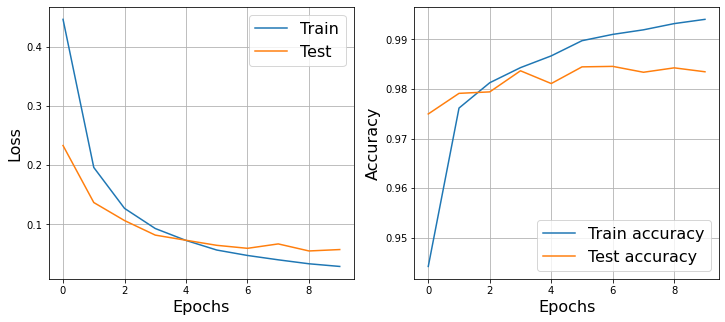

([0.4466523775286766,
  0.19617069560263964,
  0.1269679925144354,
  0.09290858095229816,
  0.07276328131635941,
  0.056517895048996535,
  0.04732567945848713,
  0.039973162960554996,
  0.03327944157307527,
  0.02876681637570961],
 [0.23328533693204953,
  0.13687569440542896,
  0.10635866870797134,
  0.08176613169946248,
  0.0730443047005919,
  0.06449623413006716,
  0.059421392157673836,
  0.06687558786000443,
  0.0549519933005677,
  0.05733436707383658],
 [0.94423527,
  0.9761682,
  0.98127663,
  0.9843195,
  0.9866904,
  0.9897499,
  0.99102145,
  0.9919432,
  0.9931981,
  0.9940532],
 [0.97498024,
  0.9791337,
  0.9794304,
  0.98368275,
  0.9811115,
  0.9844739,
  0.98457277,
  0.9833861,
  0.9842761,
  0.983485])

In [20]:
##### YOUR CODE HERE #####
from train_utils import train
sizes = [196, 512, 128, 10]
layers = []
for in_dim, out_dim in zip(sizes, sizes[1:]): 
    layers.append(nn.Linear(in_dim, out_dim))
    layers.append(nn.BatchNorm1d(out_dim))
    layers.append(nn.ReLU())
network = TestNetwork(nn.Sequential(*layers))

train(network, train_loader, test_loader, 10, 0.001)

Epoch 9... (Train/Test) NLL: 0.037/0.077	Accuracy: 0.991/0.976


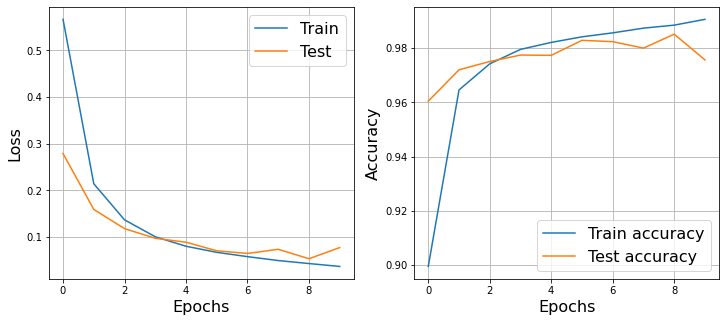

([0.5663755947847102,
  0.2141405622969304,
  0.13682654585792567,
  0.10052310247252237,
  0.08020528281596043,
  0.06716829521664933,
  0.05795771668333489,
  0.04957051763831298,
  0.04315848232530899,
  0.03694645293267456],
 [0.27889155492752415,
  0.15910721240164358,
  0.11803435373909865,
  0.09727489311672465,
  0.08886368483116355,
  0.07049287174227117,
  0.06474737172262578,
  0.07367467705773402,
  0.05346671061566736,
  0.07738795480396174],
 [0.8994148,
  0.96458554,
  0.97422487,
  0.97954977,
  0.9821262,
  0.98418623,
  0.9856521,
  0.9873956,
  0.9885006,
  0.9906383],
 [0.960443,
  0.9720135,
  0.9750791,
  0.9774525,
  0.97735363,
  0.9828916,
  0.98239714,
  0.98002374,
  0.98516613,
  0.9756725])

In [21]:
sizes = [196, 128, 128, 10]
layers = []
for in_dim, out_dim in zip(sizes, sizes[1:]): 
    layers.append(nn.Linear(in_dim, out_dim))
    layers.append(LayerNormalization(out_dim))
    layers.append(nn.ReLU())
network = TestNetwork(nn.Sequential(*layers))

train(network, train_loader, test_loader, 10, 0.001)

<i> 3.3 Сделайте выводы по третьей части </i>

Качество с Batch normalization лучше, чем с Layer normalization

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: